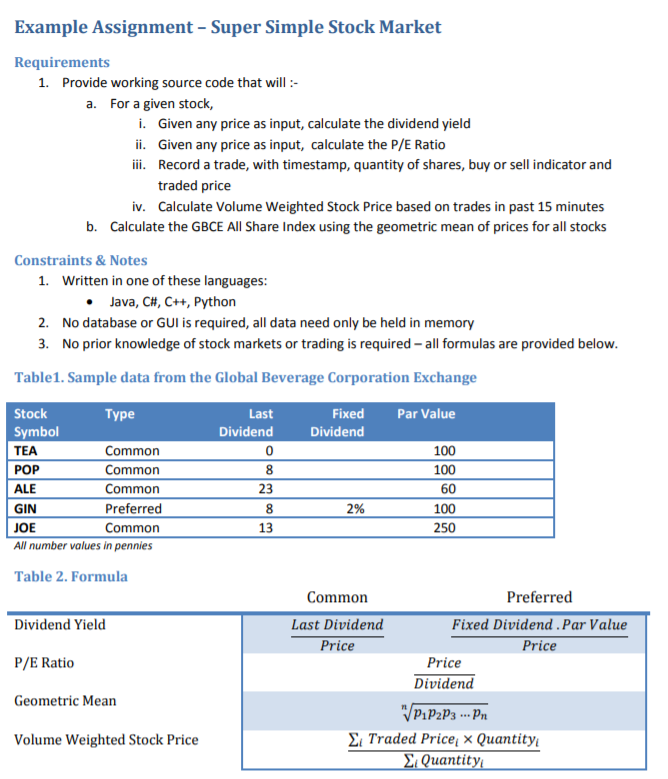

In [1]:
from IPython.display import Image
Image(filename='homework.png')

In [7]:
import pandas as pd

class ExchangeService:
    
    def __init__(self, market_data):
        self.market_data = market_data
    
    def get_stock_data(self, symbol):
        #There may be a more elegant way of checking if returned value size = 0 then throw. Ideally this should be one line.
        try:
            stock_data = self.market_data[self.market_data["Stock Symbol"] == symbol]
            if stock_data.empty:
                raise ValueError('Stock symbol not found in GSBE Index. Please check inputs and try again.')
        except ValueError as e:
            print(e)

        #Making an assumption that each stock symbol is unique and therefore only one row will ever be returned
        return stock_data.iloc[0]
    
    def dividend_yield(self, symbol, price):
        if price <= 0:
            print("Price must be greater than 0")
            return None

        stock_data = self.get_stock_data(symbol)

        if stock_data["Type"] == "Common":
            dividend_yield = stock_data["Last Dividend"]/price

        elif stock_data["Type"] == "Preferred":
            dividend_yield = stock_data["Fixed Dividend"]*stock_data["Par Value"]/price

        else:
            #Probably don't need to error handle on this as unlikely stock index would have incorrect data. 
            #For now, we'll just provide a null val and carry on
            print("Stock Type unknown, unable to calculate dividend yield");
            dividend_yield = None        

        return dividend_yield
    
    #Assumption that the 'dividend' specified in the PE ratio is the 'last dividend'. 
    def pe_ratio(self, symbol, price):
        if price <= 0:
            print("Price must be greater than 0")
            return None

        stock_data = self.get_stock_data(symbol)

        if stock_data["Last Dividend"] <= 0:
            print("No dividend available, unable to calculate PE ratio")
            return None

        return price/stock_data["Last Dividend"]        

In [3]:
import pandas as pd
import numpy as np
import datetime

class BookingService:
    
    def __init__(self, trades_booked):
        self.trades_booked = trades_booked
    
    def book_trade(self, symbol, quantity, buy_sell_ind, price):
        if quantity <= 0:
            print("Quantity of zero, ignoring trade booking")
            return
        
        timestamp = datetime.datetime.now()
        trade_data = {
            "Stock Symbol": symbol, 
            "Timestamp": timestamp, 
            "Quantity": quantity, 
            "Buy Sell Ind": buy_sell_ind, 
            "Price": price
        }
        trade = pd.DataFrame([trade_data], index=[timestamp])
        
        #Append func returns a new object, which seems unnecessary. Should look to append on same object if possible
        self.trades_booked = self.trades_booked.append(trade, sort=True)
    
    def volume_weighted_stock_price(self, symbol, duration_mins=15):
        duration_start = datetime.datetime.now() - datetime.timedelta(minutes = duration_mins)           
        
        recent_trades_booked = self.trades_booked.loc[(self.trades_booked["Timestamp"] > duration_start) & 
                                                      (self.trades_booked["Stock Symbol"] == symbol)]
    
        if recent_trades_booked.empty:
            print("No trades booked of this stock in the duration specified.")
            return None #Maybe want to provide more details other than printing.
            
        sum_traded_price = 0
        sum_quantity = 0
        
        for index, row in recent_trades_booked.iterrows():
            sum_traded_price += row["Quantity"] * row["Price"]
            sum_quantity += row["Quantity"]
        
        return sum_traded_price/sum_quantity
    
    
        
    def gsbe_all_share_index(self):
        prices = np.array(self.trades_booked["Price"].values)
        
        return prices.prod()**(1/len(prices))
        

In [8]:
class StockApplication:
    #Wrapper for injecting the services
    market_data = pd.DataFrame( [
        ["TEA", "Common", 0, None, 100],
        ["POP", "Common", 8, None, 100],
        ["ALE", "Common", 23, None, 60],
        ["GIN", "Preferred", 8, 0.02, 100],
        ["JOE", "Common", 13, None, 250]
    ],
        columns=["Stock Symbol", "Type", "Last Dividend", "Fixed Dividend", "Par Value"]
        )

    exchangeService = ExchangeService(market_data)
    
    bookingService = BookingService(pd.DataFrame( [], columns=[ "Stock Symbol", "Timestamp", "Quantity", "Buy Sell Ind", "Price"] ))

#Very basic user input to test the services. 

stock_app = StockApplication()

exchange_is_open = True
while(exchange_is_open):
    print("Welcome to the Global Beverage Corporation Exchange Stock Market");
    print("1 - Calculate the Dividend Yield \n" + 
          "2 - Calculate the P/E Ratio \n" +
          "3 - Book a Trade \n" + 
          "4 - Calculate the Volume Weighted Stock Price \n" + 
          "5 - Calculate the GBCE All Share Index \n" + 
          "6 - Close Application \n")
    
    try:
        user_option = int(input('Please enter one of the options (1-6) above: '))
    except ValueError as e:
        print("Input not recognised. Please try again")
        continue
    
    if user_option == 1:
        user_symbol = input("Please enter the symbol: ")
        user_price = int(input("Please enter the price: "))
        dividend_yield = stock_app.exchangeService.dividend_yield(user_symbol, user_price)
        print(f"Dividend Yield: {dividend_yield} \n")
    
    if user_option == 2:
        user_symbol = input("Please enter the symbol: ")
        user_price = int(input("Please enter the price: "))
        pe_ratio = stock_app.exchangeService.pe_ratio(user_symbol, user_price)
        print(f"P/E Ratio: {pe_ratio} \n")
        
    if user_option == 3:
        user_symbol = input("Please enter the symbol: ")
        user_quantity = int(input("Please enter the quantity: "))
        user_buy_sell_ind = input( "Please enter the buy sell indicator")
        user_price = int(input("Please enter the price: "))
        
        stock_app.bookingService.book_trade(user_symbol, user_quantity, user_buy_sell_ind, user_price)
        print("Trade Booked! \n")

    if user_option == 4:
        user_symbol = input("Please enter the symbol: ")
        volume_weighted_stock_price = stock_app.bookingService.volume_weighted_stock_price(symbol=user_symbol)
        print(f"Volume Weighted Stock Price: {volume_weighted_stock_price} \n")
        
    if user_option == 5:
        gsbe_all_share_index = stock_app.bookingService.gsbe_all_share_index()
        print(f"GSBE All Share Index: {gsbe_all_share_index} \n")
    
    if user_option == 6:
        print("Closing Exchange. \n")
        exchange_is_open = False